In [19]:
#imports
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import h5py
import thejoker as tj
from astropy.table import QTable, Table, Column, vstack, unique
from astropy.time import Time
from astropy.visualization.units import quantity_support

import astropy.coordinates as coord
import pymc as pm
import arviz as az

import argparse
import os

In [20]:
#random generator to ensure reproducibility? - from the joker tutorial
rnd = np.random.default_rng(seed=42)

In [21]:
#import data
data_6866 = QTable.read('/users/EllaMathews/Research/Combined_Data_6866.csv')
data_6811 = QTable.read('/users/EllaMathews/Research/Combined_Data_6811.csv')
new_data = h5py.File('/users/EllaMathews/Research/ngc6811_UTP_v1_new.h5', 'r')

In [22]:
#make list of ids to check over
ids6866 = data_6866['id']
ids6811 = data_6811['id']

In [23]:
#function that takes id and returns a RVData object 
def IDtoRV(id_num):
    rvdatamatched6866 = data_6866[id_num == ids6866] #where function to get the rows where id matches input 
    rvdatamatched6811 = data_6811[id_num == ids6811] # repeat for both clusters
    if len(rvdatamatched6866) == 0 and len(rvdatamatched6811) == 0: #if not in either cluster return nothing
        return
    if len(rvdatamatched6811) == 0: #if there is nothing from 6811 then use the data from 6866 to create RVData obj
        matched = rvdatamatched6866
    if len(rvdatamatched6866) == 0: #if there is nothing from 6866 then use the data from 6811 to create RVData obj
        matched = rvdatamatched6811
    t1 = Time(matched["hjd"], format = "jd", scale = "tcb") #create time object

    gname = matched['DR3Name'][0] #getting name of object
    gnum = gname[9:] #getting just the numbers 
    new_rv =[] #empty arrays to put new data in 
    new_rv_err = []
    new_date = []
    new = Table() #empty table
    is_group = False
    if gnum in new_data:
        is_group = isinstance(new_data[gnum], h5py.Group) #checking to see if there is new data (will be a group if there is for this id)
    if is_group:
        newstardata = new_data[gnum]['spec'] #looking in spec data
        for time in newstardata.keys(): #iterate through dates for the given name 
           t = time[-19:] # make sure just numbers
           new_rv.append(newstardata[t]['vrad'][0]) #add new rv data to the array
           new_rv_err.append(newstardata[t]['vrad'][1]) #add new rv error data to the array
           new_date.append(t) #add new dates
    new['rv'] = new_rv #add column to table with name 'rv'
    new['rve'] = new_rv_err #add column to table with name 'rve'
    t2 = Time(new_date, format = 'isot') #create new time object with new dates
    t_all = Time(np.append(t1, t2)) #merge time objects
    all_data = vstack([matched, new]) #merge tables so all rv data is together 
    data = tj.RVData(t = t_all, rv = all_data["rv"]*(u.kilometer/u.second), rv_err = all_data["rve"]*(u.kilometer/u.second)) #create RVData obj
    return data, len(all_data['rv']) #return the RVData obj and how many samples for the star

In [24]:
idcheck = 9835971

In [25]:
#random id to check if function is working
datacheck, num_samplescheck = IDtoRV(idcheck)

ID: 9835971
# of samples: 5


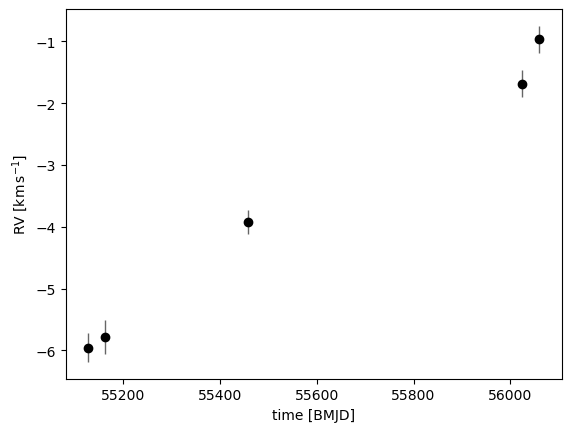

In [26]:
#check to see if works 
print('ID:', idcheck)
print('# of samples:', num_samplescheck)
_ = datacheck.plot()

In [27]:
def RunTheJoker(id_num, num_priors):
    data, num_samples = IDtoRV(id_num) #using other function to get joker object and number of samples 

    if os.path.exists(f'/users/EllaMathews/Research/{id_num}') == False:
        os.makedirs(f'/users/EllaMathews/Research/{id_num}')
        os.makedirs(f'/users/EllaMathews/Research/{id_num}/Plots')

    fig1, ax1 = plt.subplots()
    _ = data.plot() #plotting rv vs time
    fig1.savefig(f"/users/EllaMathews/Research/{id_num}/Plots/RVvsTime_{id_num}") #saving figure to plots folder in research folder
    
    prior = tj.JokerPrior.default( #initializing the default prior
        P_min = 2 * u.day,
        P_max = 1e3 * u.day,
        sigma_K0 = 30 * u.km / u.s,
        sigma_v = 100 * u.km / u.s,
    )

    if os.path.exists(f"/users/EllaMathews/Research/{id_num}/prior_samples_{id_num}.hdf5"):
        prior_samples = tj.JokerSamples.read(f"/users/EllaMathews/Research/{id_num}/prior_samples_{id_num}.hdf5")
    else:
        prior_samples = prior.sample(size = num_priors, rng = rnd) #generating prior samples
        prior_samples.write(f"/users/EllaMathews/Research/{id_num}/prior_samples_{id_num}.hdf5", overwrite = True) #write out prior samples to research folder 

    joker = tj.TheJoker(prior, rng=rnd) #creating instance of The Joker
    joker_samples = joker.rejection_sample(data, prior_samples, max_posterior_samples=256) #creating rejection samples 
    joker_samples.write(f"/users/EllaMathews/Research/{id_num}/rejection_samples_{id_num}.hdf5", overwrite = True) #writing out posterior samples (not MCMC)

    fig2, ax2 = plt.subplots()
    _ = tj.plot_rv_curves(joker_samples, data=data) #plotting RV curves from rejection sampler
    fig2.savefig(f"/users/EllaMathews/Research/{id_num}/Plots/RVCurves_{id_num}") #saving figure to plots folder in research folder

    #plotting period against eccentricity
    fig3, ax3 = plt.subplots()
    with quantity_support():
        ax3.scatter(joker_samples["P"], joker_samples["e"], s=20, lw=0, alpha=0.5)
    ax3.set_xscale("log")
    ax3.set_xlim(1, 1e3)
    ax3.set_ylim(0, 1)
    ax3.set_xlabel("$P$ [day]")
    ax3.set_ylabel("$e$")
    fig3.savefig(f"/users/EllaMathews/Research/{id_num}/Plots/PeriodvsEccent_{id_num}") #saving figure to plots folder in research folder 

    if len(joker_samples) == 1: #if only one sample need MCMC
        #MCMC with NUTS sampler 
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples)
            trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data) #convert trace into jokersamples
        mcmc_samples.write(f'/users/EllaMathews/Research/{id_num}/rejection_samples_MCMC_{id_num}.hdf5', overwrite = True) #write out MCMC posterior samples 
        
        fig4, ax4 = plt.subplots()
        _ = tj.plot_rv_curves(mcmc_samples, data=data) #plotting RV curves from MCMC rejection sampler
        fig4.savefig(f"/users/EllaMathews/Research/{id_num}/Plots/RVCurves_MCMC_{id_num}") #saving figure to plots folder in research folder
        
        #plotting period vs eccentricity
        fig5, ax5 = plt.subplots()
        with quantity_support():
            ax5.scatter(mcmc_samples["P"], mcmc_samples["e"], s=20, lw=0, alpha=0.5)
        ax5.set_xscale("log")
        ax5.set_xlim(1, 1e3)
        ax5.set_ylim(0, 1)
        ax5.set_xlabel("$P$ [day]")
        ax5.set_ylabel("$e$")
        fig5.savefig(f"/users/EllaMathews/Research/{id_num}/Plots/PeriodvsEccent_MCMC_{id_num}") #saving figure to plots folder in research folder
        
        
    return

/var/folders/4n/h8dn3ct57lq6m1bw1ytnz1x00000gn/T/ipykernel_7793/2034480169.py:48: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Output()

Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


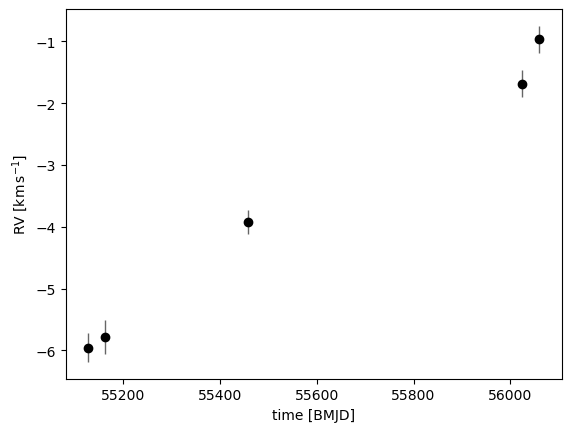

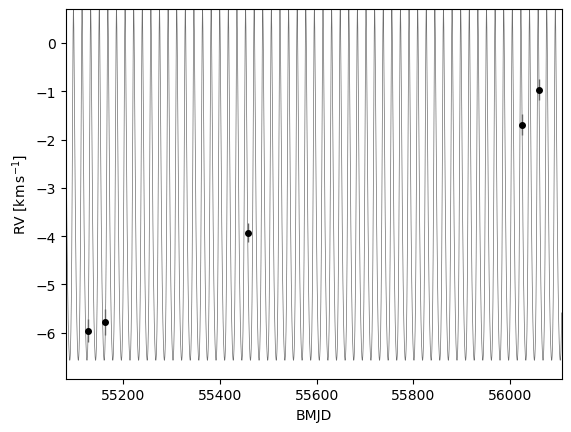

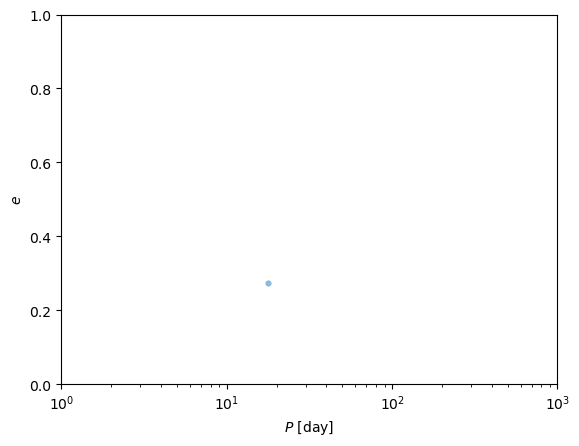

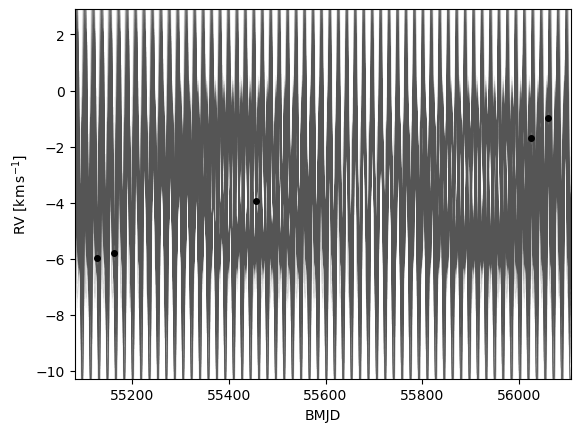

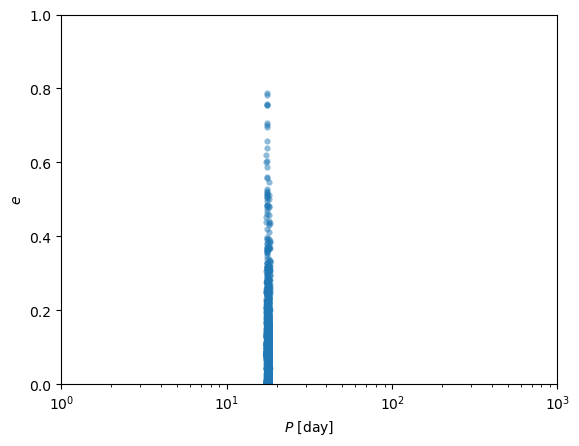

In [28]:
#check if working
RunTheJoker(idcheck,1000)

In [30]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('id', help = 'star id', type = int)
    parser.add_argument('--prior', help = 'num of prior samples, default 1000', type = int, default =1000)
    args = parser.parse_args()
    
    RunTheJoker(args.id, args.prior)

usage: ipykernel_launcher.py [-h] [--prior PRIOR] id
ipykernel_launcher.py: error: argument id: invalid int value: '/Users/EllaMathews/Library/Jupyter/runtime/kernel-21d63714-0341-4187-8234-ad5004931b0c.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'